In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from qutip import *
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, find_peaks

The single qubit simulation will use system constants from Schuster's thesis: Circuit Quantum Electrodynamics. The Qutip notebook the code is derived from can be found at: https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb.
\\
This simulation makes use of the Jaynes-Cummings Hamiltonian: \\
$$\hat{H}/\hbar = \omega_c\hat{a}^{†}a + \frac{1}{2}\omega_q\hat{\sigma}_z + \frac{1}{2}g(\hat{a}\hat{\sigma}_+ + \hat{a}^{†}\hat{\sigma}_-)$$

### Setting the system constants
All constant in units of GHz, the set values are from Schuster. Time is in units of nanoseconds.

In [3]:
# Cavity frequency
wc = 5.5 * 2 * np.pi
#detuning 
delta = 0
#qubit frequency
wq = wc + delta*2*np.pi
#coupling
g = 0.017 * 2 * np.pi
# number of energy levels in the cavity
N = 20
# use rotating wave approx. or not
use_rwa = True
# cavity dissapation rate
kappa = 0.005 * 2 * np.pi 
# qubit dissapation rate
gamma = 0.002 * 2 * np.pi * kappa


#the list of times to evolve the system over
tlist = np.linspace(0, 50, 101)

### Calculate the Theoretical Rabi Frequency
We can calculate the Rabi frequency for the Jaynes-Cummings model to compare the simulation value to later

In [31]:
rabi_f = sqrt(4*(g**2) + (wq-wc)**2)
print(rabi_f)

0.21362830044410594


### Operators and Hamiltonian
The destroy() and qeye() matrices are default Fock basis, with the specified size. 

In [5]:
# annhiliation and spin operator
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))


#number of photons in cavity, and in qubit (operators)
nc = a.dag() * a
nq = sm.dag() * sm # where sz = sm.dag * sm

#Hamiltonian: Jaynes-Cumming
if use_rwa:
    H = wc * nc + wq * nq + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * nc + wq * nq + g * (a.dag() + a) * (sm + sm.dag())

### Time Evolution of the System
First we place quanta in the qubit excited state, with the cavity remaining in ground state. We define the collapse operators to add noise to our system. We specify expectation values we are interested in finding - namely the number of quanta in the qubit and the number of quanta in the cavity. 

In [8]:
# initial state of the system
psi0 = tensor(basis(N,0), basis(2,1))
collapse_ops = [sqrt(kappa)*a, sqrt(gamma) * sm]

output = mesolve(H, psi0, tlist, collapse_ops, [nc, na], options=Options(nsteps=10000))

### Graphing the Output
Now we can graph the output expectation values according to the system evolution. First we do this without fitting:

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

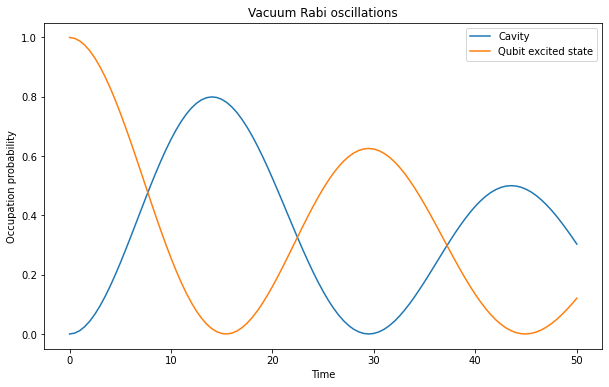

In [20]:
# expectation for number of quanta in qubit over tlist
n_q = output.expect[0]
# ditto for the cavity
n_c = output.expect[1]

# create the figure + plot the results
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_q, label="Cavity")
axes.plot(tlist, n_c, label="Qubit excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')

#### Adding the fit function
We can now fit a curve and get the simulated Rabi frequency. This requires a few helper functions.

In [21]:
def time_for_val(times, output, outputs):
    """
    returns: the time (or x val) at which a desired output occurs
    params: times - list of x values
        output - the output of interest to match x value to
        outputs - the total list of outputs
    """
    # the margin that values should be in to get result
    val_range = 0.01
    # first find the desired output in the outputs list
    out_idxL = np.where(abs(outputs-output) <= val_range)
    timesL = times[out_idxL]
    
    #trim so that it only includes time values that are notably different
    timesL = np.array(timesL)
    timesL = np.around(timesL, 9) # since we are in the GHz range we want the same order of accuracy
    timesL = np.unique(timesL)
    return timesL


def freq_guesser(data):
    """
    returns: frequency of periodic behaviour for input data set
    params: data - numpy array of data to be processed
    warnings: local maxima must be distinct / more than two or
            error will be thrown
    """
    if np.size(data) == 0:
        return 0
    else:
        peak_ind = find_peaks(data)[0]
        T = tlist[peak_ind[1]] - tlist[peak_ind[0]]
        freq=1/T
        return freq
    
    
def init_guesser(dataset, tlist):
    """
    returns: the approximate dataset params to be fed into curve_fit function
    params: dataset - numpy array of the data to be processed
            tlist - the times (x values) the data iterates over
    """
    # amplitude of sinusoid
    amp = (max(dataset) - min(dataset))/2
    # frequency of sinusoid
    freq = freq_guesser(dataset)
    # phase shift of sinusoid 
    phase = 0
    # vertical shift of sinusoid
    shift = amp + min(dataset) 
    
    
    peak_ind = find_peaks(dataset)[0] # get np.array in a tuple of the local maxima indices of the qubit
    if kappa==0 and gamma ==0:
        return amp, freq, phase, shift
    else:
        # exponential damping of sinusoid due to dissipation 
        damp = -(np.log(dataset[peak_ind[0]]))/(tlist[peak_ind[0]])
        return amp, freq, phase, shift, damp


def get_fit(init_guess):
    """
    returns: the fit function for some given initial guess
    params: init_guess - [amp,freq,phase,shift,damp] where damping is
                        added when there is dissipation
    """
    if kappa==0 and gamma==0:
        def init_func(t, amp, freq, phase, shift):
            return amp*(np.sin(freq*t + phase))**2 + shift

        param, param_cov = curve_fit(init_func, tlist, n_q, maxfev=500000, p0=init_guess)
        fit_func = param[0]*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    else:
        def init_func(t, amp, freq, phase, shift, damp):
            return amp*np.exp(-damp*t)*(np.sin(freq*t + phase))**2 + shift

        param, param_cov = curve_fit(init_func, tlist, n_q, maxfev=500000, p0=init_guess)
        fit_func = param[0]*np.exp(-param[4]*tlist)*((np.sin(param[1]*tlist + param[2]))**2) + param[3]
    return param, fit_func

Rabi Frequency from fitting: 0.21306607070927533 GHz


Text(0.5, 1.0, 'Vacuum Rabi oscillations')

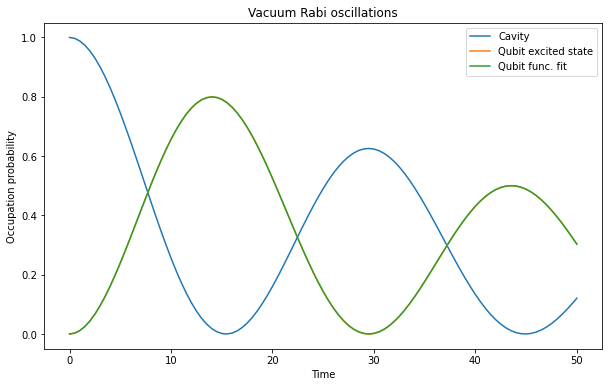

In [33]:
init_guess = init_guesser(n_q,tlist)
param, fit_func = get_fit(init_guess)
rabi_fit_f = abs(2*param[1])
print(f"Rabi Frequency from fitting: {rabi_fit_f} GHz")

fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_q, label="Qubit excited state")
axes.plot(tlist, fit_func, label="Qubit func. fit")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')

### Calculate Rabi Frequency Accuracy

In [35]:
accuracy = abs(rabi_f - rabi_fit_f)/rabi_f
print(accuracy)

0.0026318129838687416
